# Fit models to NYC data

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline
import seaborn as sns
from scipy.integrate import ode
from scipy import optimize

In [3]:
ny_df = pd.read_csv('../data/processed/nyc_data.csv', parse_dates = True)
dates = ny_df['DATE_OF_INTEREST']
cum_cases = ny_df['Cumulative_Deaths'] / 0.01 # Assumed proportion of deaths
cum_cases = cum_cases.as_matrix()

In [53]:
# Population parameters
N = 8.39e6
I0 = 10
R0 = 0
S0 = N - I0 - R0
y0 = (S0, I0, R0)

gamma = 1/14

In [200]:
## SIR Model (stationary, t for odeint compliance)
def deriv(y, t, N, beta, gamma, pi):
    S, I, R = y
    #gamma = 1/max(np.random.normal(14,4), 7)
    #beta = max(1,np.random.normal(2.28, 1)) * gamma
    dSdt = -beta * S * I / N * pi[int(t)]
    dIdt = beta * S * I / N * pi[int(t)] - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def time_step(deriv, y0, ts, args):
    states = [np.asarray(y0)]
    for dt,t in zip(ts[1:] - ts[:-1], ts[1:]):
        curr = states[-1]
        derivatives = np.asarray(deriv(curr, t, *args))
        states.append(curr + derivatives*dt)

    return np.asarray(states)

def exp(low, dt, t0, ts):
    """
    low : the asymptotic reduced contact level
    dt : number of days to get within 0.05 of `low`
    t0 : when measure are implemented
    ts : the time range
    """
    #c = -np.log((2 - low/100) / (1 - low/100)) / dt
    c = np.log(0.05 / (1 - low/100)) / dt
    pi = np.ones(len(ts) + 1)
    pi[t0:-1] = (1 - low/100) * np.exp(c*(ts[t0:]-ts[t0])) + low/100

    return(pi)

In [209]:
## Loss to penalize undershooting
def loss(z, c=1):
    f0 = lambda xs: [c*x**2 if x < 0 else x**2 for x in xs]
    f1 = lambda xs: [c*2*x if x < 0 else 2*x for x in xs]
    f2 = lambda xs: [c*2 if x < 0 else 2 for x in xs]

    #return(np.vstack((f0(z), f1(z), f2(z))))
    return(np.sum(np.asarray(f0(z))))

In [354]:
# args = (r0, relative_start, changed interaction percent, days to decrease interaction by half, onset of changes)
def residuals(args):
    r0, l, low, dt, t0 = args
    l,t0 = int(l), int(t0)
    beta = r0 * gamma
    time_range = np.arange(0,len(dates) + l + 300)
    pi = exp(low, dt, t0, time_range)
    sim = time_step(deriv, y0, time_range, args=(N,beta,gamma, pi))
    _,I,_ = sim.T
    residuals = np.concatenate((np.zeros(90-l), I[:l], I[l:l+len(dates)] - cum_cases, I[l+len(dates):]))

    return(loss(residuals, c=20))


## Optimize
Priors
 - R0 : from literature
 - l : from estimated first case
 - low : from google mobility data
 - dt : estimated from quick response to shut downs, google data
 - t0 : NYC shutdown order (March 7th) vs case onset (March 3rd) vs first case estimate (l) or google data

In [363]:
# r0, l, low, dt, t0
args0 = [2.28,21,40,19,21]
#argmins = [2, 14, 30, 1, 14]
#argmaxs = [6, 90, 60, 14, 120]
argmins = [2,0,15,7,0]
argmaxs = [6,40,50,35,40]

In [360]:
res = optimize.minimize(residuals, args0, bounds=np.asarray([argmins, argmaxs]).T)

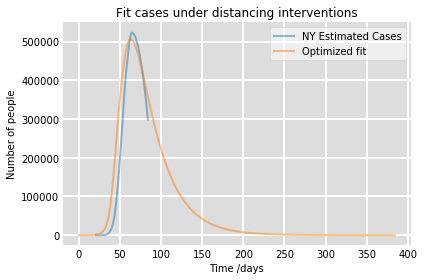

In [367]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

## Plot
r0, l, low, dt, t0 = res.x
l,t0 = int(l), int(t0)
beta = r0 * gamma
time_range = np.arange(0,len(dates) + l + 300)
pi = exp(low, dt, t0, time_range)
sim = time_step(deriv, y0, time_range, args=(N,beta,gamma, pi))
S,I,R = sim.T

ax.plot(time_range[l:l+len(dates)], cum_cases, alpha=0.5, lw=2, linestyle='-',label='NY Estimated Cases')

ax.plot(time_range, I, alpha=0.5, lw=2, linestyle='-',label='Optimized fit')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of people')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.title(f"Fit cases under distancing interventions")
plt.tight_layout()
plt.savefig('../figures/fit_cases.png')
plt.show()


In [366]:
params = ['r0', 'l', 'low', 'dt', 't0']
for p,x in zip(params,res.x):
    print(f'{p}: {x}')

r0: 4.684684301740341
l: 21.0
low: 15.0
dt: 33.55106517261918
t0: 38.0


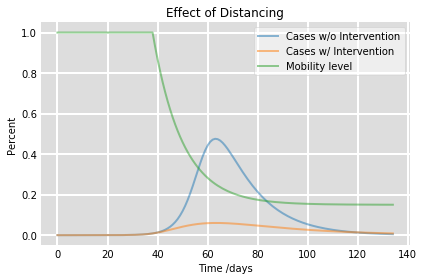

In [375]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

## Plot
r0, l, low, dt, t0 = res.x
l,t0 = int(l), int(t0)
beta = r0 * gamma
time_range = np.arange(0,len(dates) + l + 50)
pi = exp(low, dt, t0, time_range)

sim = time_step(deriv, y0, time_range, args=(N,beta,gamma, np.ones(len(pi))))
S,I,R = sim.T
ax.plot(time_range, I/N, alpha=0.5, lw=2, linestyle='-',label='Cases w/o Intervention')

sim = time_step(deriv, y0, time_range, args=(N,beta,gamma, pi))
S,I,R = sim.T
ax.plot(time_range, I/N, alpha=0.5, lw=2, linestyle='-',label='Cases w/ Intervention')


ax.plot(time_range, pi[:-1], alpha=0.5, lw=2, linestyle='-',label='Mobility level')

ax.set_xlabel('Time /days')
ax.set_ylabel('Percent')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.title(f"Effect of Distancing")
plt.tight_layout()
plt.savefig('../figures/intervention_effect.png')
plt.show()
